<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/lec_code/12_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder**
- 고차원 입력자료를 정보의 손실 없이 저차원의 잠재변수로 전환하여, 잠재변수로부터 원래 입력 자료를 재현하는 것!

In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist   # mnist data에 auto encoder 적용해서 재현하기
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [4]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train.shape

(60000, 28, 28, 1)

# Encoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


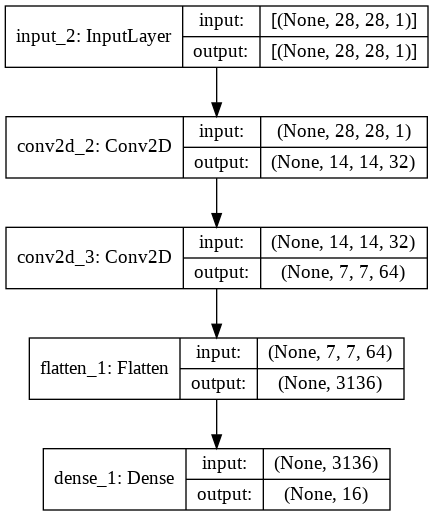

In [6]:
inputs = Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu', strides=2, padding='same')(inputs)
x=Conv2D(64,3,activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent_z = Dense(16)(x)   # latent variable 정의 !

encoder = Model(inputs,latent_z)
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)


# Decoder

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

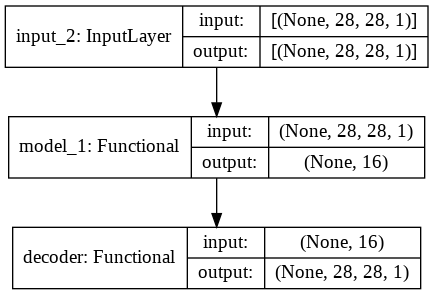

In [7]:
latent_inputs = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
x_tilde= Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, x_tilde, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

autoencoder = Model(inputs,
                    decoder(encoder(inputs)))
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)


In [8]:
autoencoder=Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=10, batch_size=32)   # 입력과 Output이 모두 X_train, X_train

Epoch 1/10
1875/1875 [==============================] - 23s 4ms/step - loss: 0.0025 - val_loss: 1.7526e-06
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7526e-06
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7526e-06
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7526e-06
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7526e-06
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7526e-06
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7525e-06
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7525e-06
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7225e-06 - val_loss: 1.7525e-06
Epoch 10/10
1

In [9]:
x_decoded = autoencoder.predict(x_test)

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs.shape

(16, 28, 28, 1)

In [10]:
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs.shape

(4, 4, 28, 28)

In [11]:
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs.shape

(112, 112)

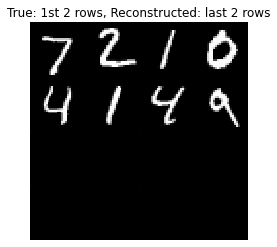

In [12]:
plt.figure()
plt.axis('off')
plt.title('True: 1st 2 rows, Reconstructed: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

# **Denoising Autoencoder**
- 노이즈가 추가된 오염제거 오토인코더! 

In [13]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [14]:
####################### 노이즈를 추가한다 #####################################3
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)    # 정규분포로 생성하기
x_train_noise = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

x_train_noise = np.clip(x_train_noise, 0., 1.)   # np.clip을 이용해 not bounded한 noise의 범위를 0~1로 조정
x_test_noise = np.clip(x_test_noise, 0., 1.)

In [15]:
inputs = Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu', strides=2, padding='same')(inputs)
x=Conv2D(64,3,activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent_z = Dense(16)(x)

encoder = Model(inputs,latent_z)

latent_inputs = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
x_tilde= Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, x_tilde, name='decoder')
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train_noise,
                x_train,
                validation_data=(x_test_noise, x_test),
                epochs=10,
                batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0349 - val_loss: 0.0203
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.015

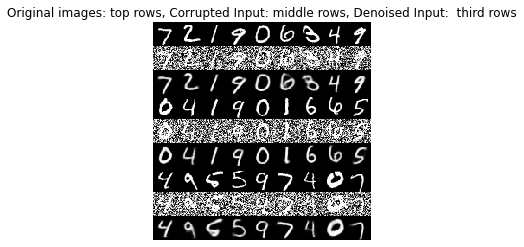

In [16]:
x_decoded = autoencoder.predict(x_test_noise)

imgs = np.concatenate([x_test[:27], x_test_noise[:27], x_decoded[:27]])
imgs = imgs.reshape((9,9, x_test.shape[1],x_test.shape[1]))
imgs = np.vstack(np.split(imgs, 3, axis=1))
imgs = imgs.reshape((9, -1, x_test.shape[1],x_test.shape[1]))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()